In [1]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.fit_psf import *
from decode_fish.funcs.dataset import EstimateBackground

from decode_fish.engine.psf import LinearInterpolatedPSF

In [55]:
path_tif = Path('//groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/sgg_smFISH_3.tif')
bead_vol = load_tiff_image(path_tif)
estimate_backg = EstimateBackground(10, 1)
print(bead_vol.shape)

torch.Size([1, 27, 512, 512])


In [56]:
bead_vol_no_bg = bead_vol - estimate_backg(bead_vol)

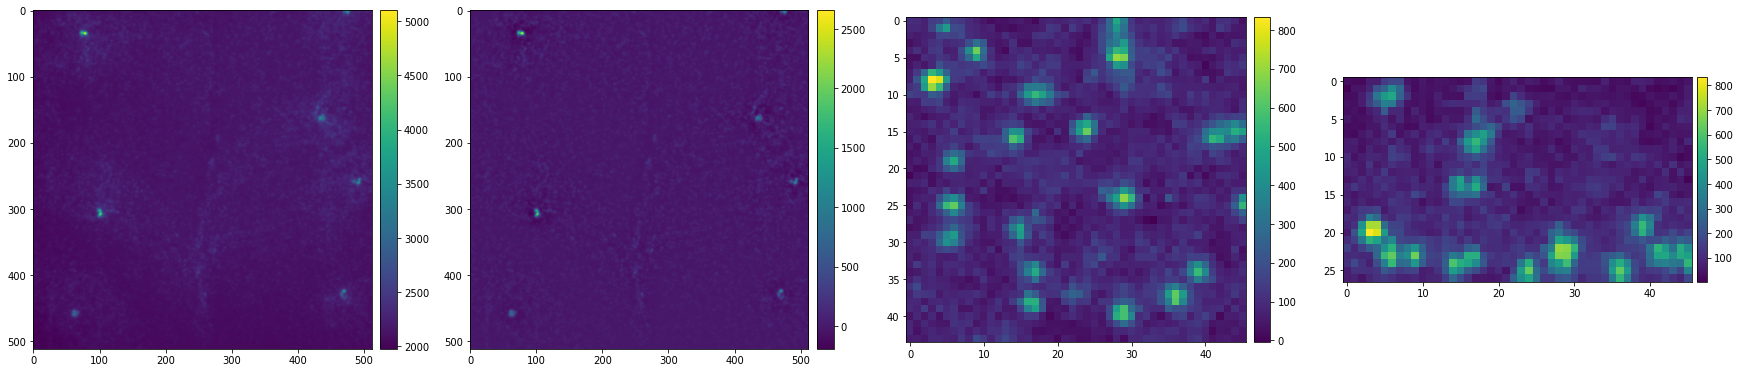

In [57]:
win_sl = np.s_[0,:,126:170,196:242]


plt.figure(figsize=(30,10))
plt.subplot(141)
im = plt.imshow(bead_vol[0].mean(0))
add_colorbar(im)
plt.subplot(142)
im = plt.imshow(bead_vol_no_bg[0].mean(0))
add_colorbar(im)
plt.subplot(143)
im = plt.imshow(bead_vol_no_bg[win_sl].max(0).values)
add_colorbar(im)
plt.subplot(144)
im = plt.imshow(bead_vol_no_bg[win_sl].max(1).values)
add_colorbar(im)

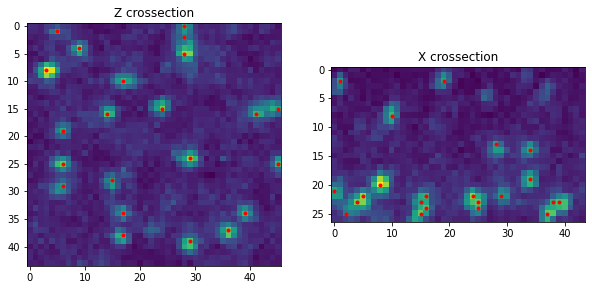

In [58]:
coords_xyz = get_peaks_3d(bead_vol_no_bg[win_sl], threshold=300, min_distance=4)
plot_detection(bead_vol_no_bg[win_sl], coords_xyz)

In [59]:
abs_coords_xyz = np.array([c + np.array([int(win_sl[3].start or 0), int(win_sl[2].start or 0), int(win_sl[1].start or 0)]) for c in coords_xyz])

In [60]:
rois = extract_roi(bead_vol_no_bg, abs_coords_xyz, size_xy=5, size_z=5)

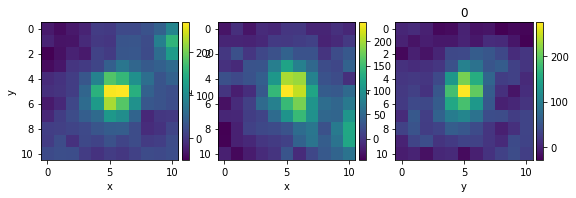

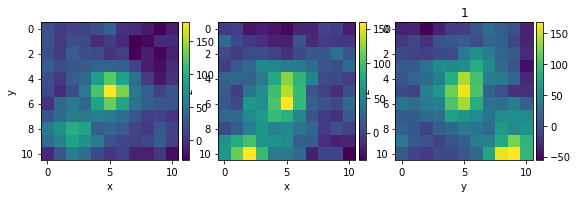

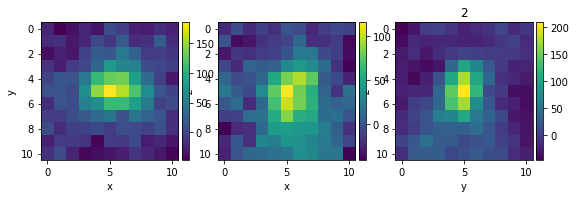

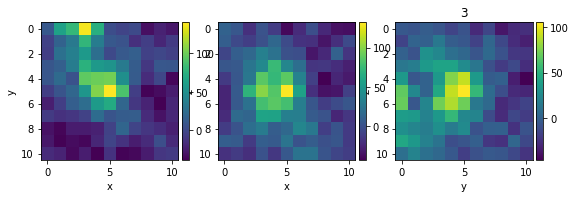

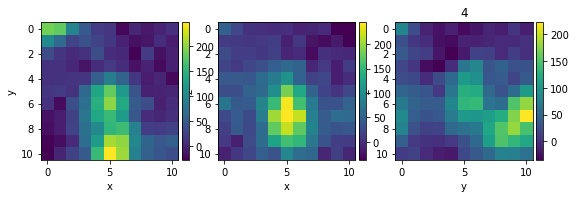

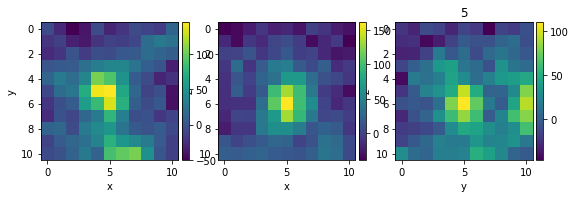

In [61]:
for i in range(len(rois)): 
    plot_3d_projections(rois[i], projection='mean', size=3);
    plt.title(i)

In [62]:
print(rois.shape)
rois_clean = rois
# rois_clean = rois_clean - rois_clean.min(-1).values.min(-1).values.min(-1).values[:,None,None,None]
rois_normed = rois_clean/rois_clean.sum(-1).sum(-1).sum(-1)[:,None,None,None] * 100

extend = [0,3,3,3]
rois_extended = torch.zeros([s + 2*e for s,e in zip(rois_normed.shape,extend)])
rois_extended[:,extend[1]:-extend[1],extend[2]:-extend[2],extend[3]:-extend[3]] = rois_normed

torch.Size([6, 11, 11, 11])


In [63]:
device='cuda'
PSF = LinearInterpolatedPSF(rois_extended.shape[-3:],1, device=device)

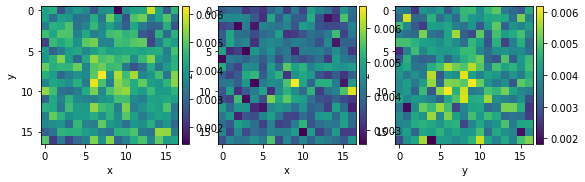

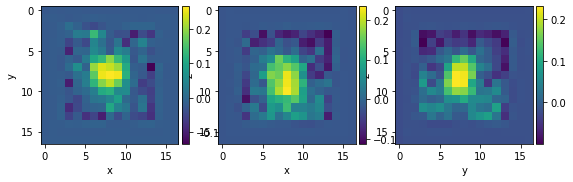

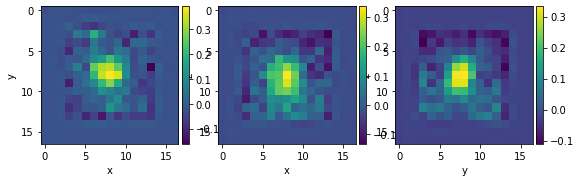

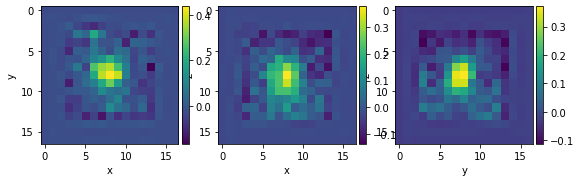

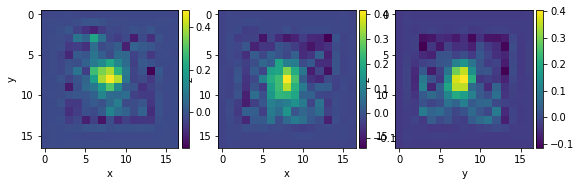

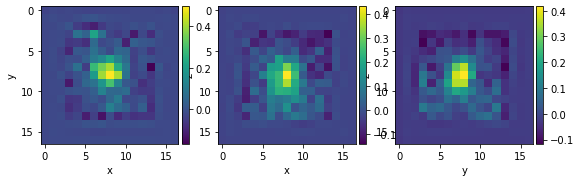

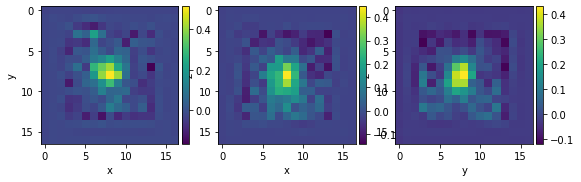

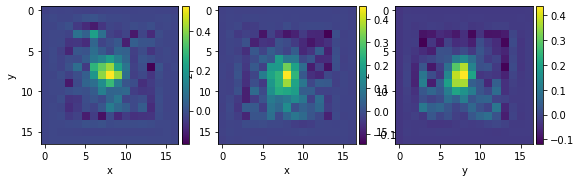

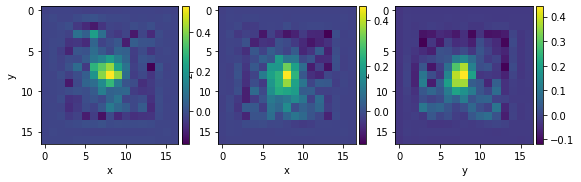

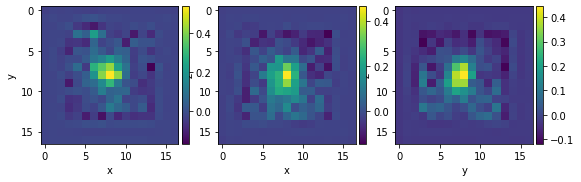

In [64]:
loss_res = fit_psf(PSF, rois_extended)

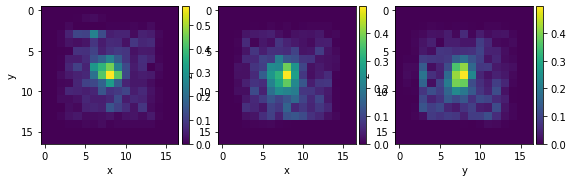

In [68]:
plot_3d_projections(torch.clamp_min(PSF.psf_volume[0],0), projection='mean', size=3);

In [69]:
PSF.psf_volume.data = torch.clamp_min_(PSF.psf_volume.data, 0) 

Text(0.5, 1.0, '0.017226597294211388')

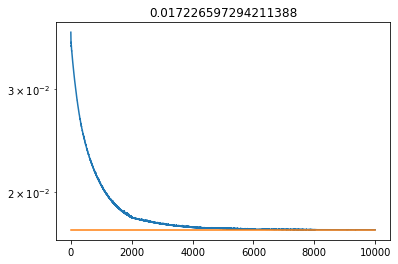

In [70]:
plt.plot(loss_res)
plt.yscale('log')
plt.plot([0,10000],[np.min(loss_res),np.min(loss_res)])
plt.title(np.min(loss_res))

In [71]:
torch.save(PSF.state_dict(), 'data/sgg_smFISH_3_psf.pkl')